<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Transformabad


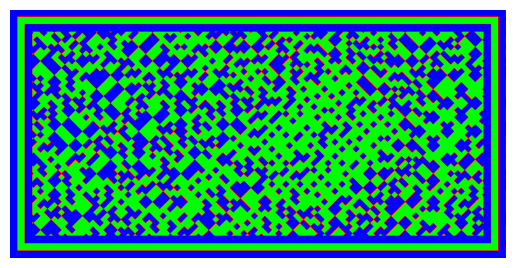

In [62]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [8]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [10]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [70]:
# model = nn.Sequential(
#     sc.Slice(rotation=4, reflection=False),
#     sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
#     nn.ReLU(inplace=True),
#     sc.SymmetryPool(),
#     nn.BatchNorm2d(32),
#     nn.Conv2d(32, 64, kernel_size=4, stride=3),
#     nn.ReLU(inplace=True),
#     sc.Slice(rotation=4, reflection=False),
#     sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
#     nn.ReLU(inplace=True),
#     sc.SymmetryPool(),
#     nn.BatchNorm2d(10),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(40, 100),
#     nn.ReLU(inplace=True),
# )

model = nn.Sequential(
    sc.Slice(rotation=4, reflection=True),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=True),  # 4 * 4
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    sc.Slice(rotation=1, reflection=False),
    sc.SymmetryConv2d(32, 64, kernel_size=3, stride=3, rotation=1, reflection=False),   # 3 * 3 
    nn.ReLU(inplace=True),  
    sc.SymmetryPool(),
    sc.Slice(rotation=4, reflection=True),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=True), # 8 * 5
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 3),
    nn.ReLU(inplace=True),
)

 10%|█         | 1/10 [00:25<03:46, 25.13s/it]

EPOCH: 01/10 LOSS: 1.0926 ACC: 0.3869  VAL-LOSS: 1.0841 VAL-ACC: 0.3805  TEST-LOSS: 1.0927 TEST-ACC: 0.3840 


 20%|██        | 2/10 [00:51<03:26, 25.87s/it]

EPOCH: 02/10 LOSS: 1.0573 ACC: 0.4283  VAL-LOSS: 1.0537 VAL-ACC: 0.4370  TEST-LOSS: 1.0396 TEST-ACC: 0.4960 


 30%|███       | 3/10 [01:17<03:01, 25.90s/it]

EPOCH: 03/10 LOSS: 1.0145 ACC: 0.4783  VAL-LOSS: 1.0039 VAL-ACC: 0.4835  TEST-LOSS: 0.9996 TEST-ACC: 0.5260 


 40%|████      | 4/10 [01:43<02:34, 25.78s/it]

EPOCH: 04/10 LOSS: 0.9229 ACC: 0.5461  VAL-LOSS: 0.8814 VAL-ACC: 0.5670  TEST-LOSS: 0.9138 TEST-ACC: 0.5520 


 50%|█████     | 5/10 [02:07<02:06, 25.31s/it]

EPOCH: 05/10 LOSS: 0.7025 ACC: 0.6755  VAL-LOSS: 0.6193 VAL-ACC: 0.7140  TEST-LOSS: 0.6581 TEST-ACC: 0.6840 


 60%|██████    | 6/10 [02:32<01:40, 25.06s/it]

EPOCH: 06/10 LOSS: 0.4417 ACC: 0.8179  VAL-LOSS: 0.4105 VAL-ACC: 0.8285  TEST-LOSS: 0.3955 TEST-ACC: 0.8340 


 70%|███████   | 7/10 [02:57<01:15, 25.05s/it]

EPOCH: 07/10 LOSS: 0.2451 ACC: 0.9064  VAL-LOSS: 0.2324 VAL-ACC: 0.9205  TEST-LOSS: 0.2154 TEST-ACC: 0.9120 


 80%|████████  | 8/10 [03:22<00:50, 25.27s/it]

EPOCH: 08/10 LOSS: 0.1434 ACC: 0.9457  VAL-LOSS: 0.1706 VAL-ACC: 0.9400  TEST-LOSS: 0.1741 TEST-ACC: 0.9360 


 90%|█████████ | 9/10 [03:47<00:25, 25.03s/it]

EPOCH: 09/10 LOSS: 0.0869 ACC: 0.9681  VAL-LOSS: 0.1354 VAL-ACC: 0.9560  TEST-LOSS: 0.1570 TEST-ACC: 0.9420 


100%|██████████| 10/10 [04:13<00:00, 25.31s/it]

EPOCH: 10/10 LOSS: 0.0652 ACC: 0.9768  VAL-LOSS: 0.1311 VAL-ACC: 0.9545  TEST-LOSS: 0.1095 TEST-ACC: 0.9560 


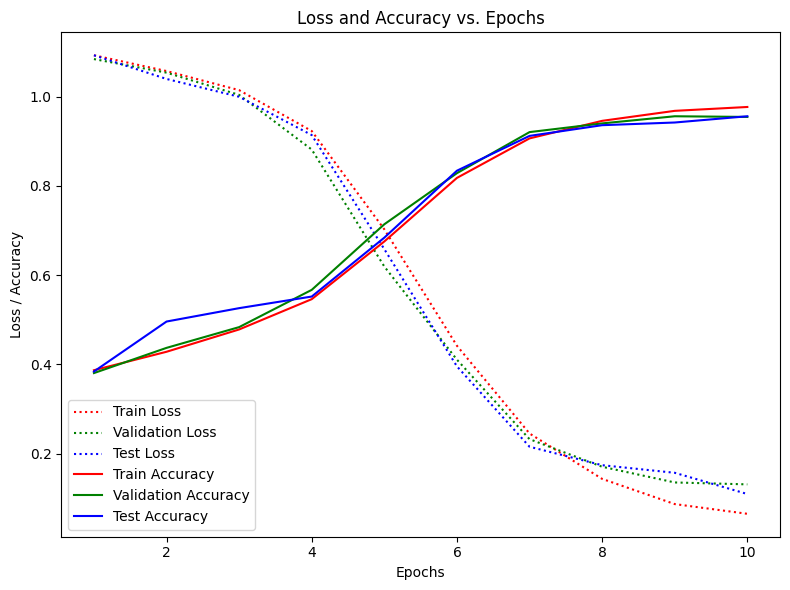

In [71]:
from torch import optim

lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

 10%|█         | 1/10 [00:08<01:18,  8.74s/it]

EPOCH: 01/10 LOSS: 1.5686 ACC: 0.3433  VAL-LOSS: 1.0965 VAL-ACC: 0.4375  TEST-LOSS: 1.1060 TEST-ACC: 0.4340 


 20%|██        | 2/10 [00:17<01:09,  8.74s/it]

EPOCH: 02/10 LOSS: 0.8314 ACC: 0.5924  VAL-LOSS: 0.6088 VAL-ACC: 0.7185  TEST-LOSS: 0.5978 TEST-ACC: 0.7360 


 30%|███       | 3/10 [00:26<01:00,  8.66s/it]

EPOCH: 03/10 LOSS: 0.4536 ACC: 0.8092  VAL-LOSS: 0.3563 VAL-ACC: 0.8570  TEST-LOSS: 0.3954 TEST-ACC: 0.8240 


 40%|████      | 4/10 [00:34<00:51,  8.59s/it]

EPOCH: 04/10 LOSS: 0.2190 ACC: 0.9199  VAL-LOSS: 0.2009 VAL-ACC: 0.9230  TEST-LOSS: 0.1838 TEST-ACC: 0.9320 


 50%|█████     | 5/10 [00:42<00:42,  8.55s/it]

EPOCH: 05/10 LOSS: 0.1344 ACC: 0.9495  VAL-LOSS: 0.1918 VAL-ACC: 0.9325  TEST-LOSS: 0.1672 TEST-ACC: 0.9260 


 60%|██████    | 6/10 [00:52<00:34,  8.71s/it]

EPOCH: 06/10 LOSS: 0.1019 ACC: 0.9603  VAL-LOSS: 0.1329 VAL-ACC: 0.9600  TEST-LOSS: 0.1138 TEST-ACC: 0.9600 


 70%|███████   | 7/10 [01:00<00:26,  8.77s/it]

EPOCH: 07/10 LOSS: 0.0774 ACC: 0.9700  VAL-LOSS: 0.2181 VAL-ACC: 0.9535  TEST-LOSS: 0.1664 TEST-ACC: 0.9560 


 80%|████████  | 8/10 [01:09<00:17,  8.78s/it]

EPOCH: 08/10 LOSS: 0.0646 ACC: 0.9761  VAL-LOSS: 0.1073 VAL-ACC: 0.9700  TEST-LOSS: 0.0688 TEST-ACC: 0.9720 


 90%|█████████ | 9/10 [01:18<00:08,  8.81s/it]

EPOCH: 09/10 LOSS: 0.0410 ACC: 0.9852  VAL-LOSS: 0.1058 VAL-ACC: 0.9720  TEST-LOSS: 0.0794 TEST-ACC: 0.9720 


100%|██████████| 10/10 [01:27<00:00,  8.74s/it]

EPOCH: 10/10 LOSS: 0.0324 ACC: 0.9881  VAL-LOSS: 0.1634 VAL-ACC: 0.9680  TEST-LOSS: 0.0777 TEST-ACC: 0.9800 


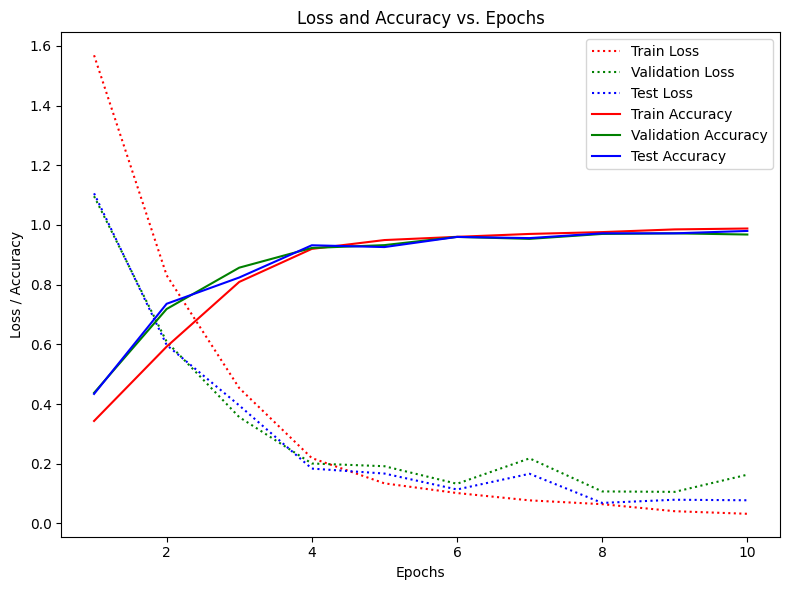

In [14]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False),  # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16),  # Adjust the batch normalization layer accordingly
    nn.Conv2d(16, 64, kernel_size=4, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

 10%|█         | 1/10 [00:13<01:59, 13.32s/it]

EPOCH: 01/10 LOSS: 1.5196 ACC: 0.3733  VAL-LOSS: 0.9945 VAL-ACC: 0.5005  TEST-LOSS: 0.9877 TEST-ACC: 0.5160 


 20%|██        | 2/10 [00:26<01:46, 13.25s/it]

EPOCH: 02/10 LOSS: 0.7559 ACC: 0.6460  VAL-LOSS: 0.5554 VAL-ACC: 0.7615  TEST-LOSS: 0.5854 TEST-ACC: 0.7520 


 30%|███       | 3/10 [00:39<01:32, 13.22s/it]

EPOCH: 03/10 LOSS: 0.3184 ACC: 0.8664  VAL-LOSS: 0.2854 VAL-ACC: 0.8955  TEST-LOSS: 0.2284 TEST-ACC: 0.9200 


 40%|████      | 4/10 [00:53<01:19, 13.31s/it]

EPOCH: 04/10 LOSS: 0.1487 ACC: 0.9443  VAL-LOSS: 0.1643 VAL-ACC: 0.9335  TEST-LOSS: 0.1496 TEST-ACC: 0.9460 


 50%|█████     | 5/10 [01:07<01:07, 13.60s/it]

EPOCH: 05/10 LOSS: 0.1009 ACC: 0.9599  VAL-LOSS: 0.1835 VAL-ACC: 0.9315  TEST-LOSS: 0.1666 TEST-ACC: 0.9320 


 60%|██████    | 6/10 [01:21<00:54, 13.71s/it]

EPOCH: 06/10 LOSS: 0.0636 ACC: 0.9748  VAL-LOSS: 0.2428 VAL-ACC: 0.9330  TEST-LOSS: 0.2205 TEST-ACC: 0.9400 


 70%|███████   | 7/10 [01:35<00:41, 13.77s/it]

EPOCH: 07/10 LOSS: 0.0443 ACC: 0.9831  VAL-LOSS: 0.1138 VAL-ACC: 0.9605  TEST-LOSS: 0.0886 TEST-ACC: 0.9700 


 80%|████████  | 8/10 [01:48<00:27, 13.81s/it]

EPOCH: 08/10 LOSS: 0.0232 ACC: 0.9912  VAL-LOSS: 0.0807 VAL-ACC: 0.9705  TEST-LOSS: 0.0776 TEST-ACC: 0.9840 


 90%|█████████ | 9/10 [02:02<00:13, 13.83s/it]

EPOCH: 09/10 LOSS: 0.0321 ACC: 0.9884  VAL-LOSS: 0.0906 VAL-ACC: 0.9645  TEST-LOSS: 0.1057 TEST-ACC: 0.9620 


100%|██████████| 10/10 [02:16<00:00, 13.66s/it]

EPOCH: 10/10 LOSS: 0.0161 ACC: 0.9947  VAL-LOSS: 0.0972 VAL-ACC: 0.9690  TEST-LOSS: 0.0997 TEST-ACC: 0.9680 


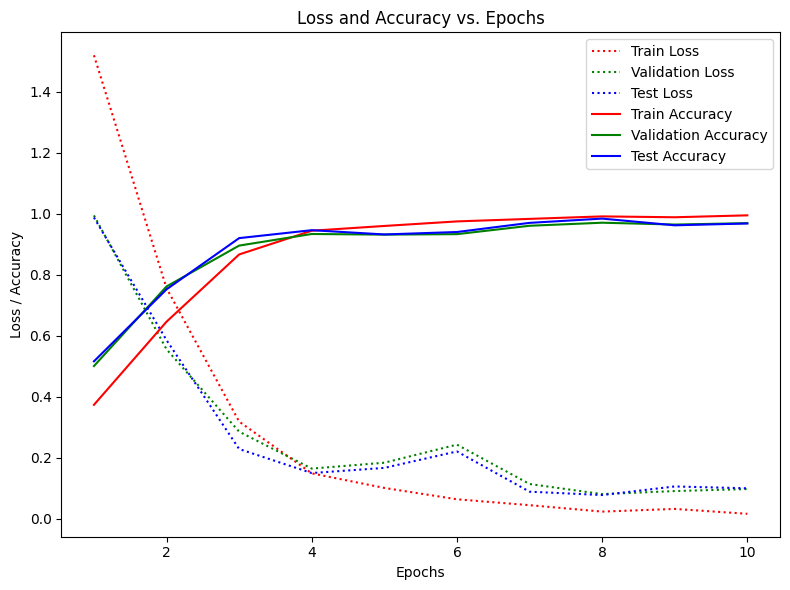

In [15]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=4, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

 10%|█         | 1/10 [00:13<01:59, 13.28s/it]

EPOCH: 01/10 LOSS: 2.4185 ACC: 0.3628  VAL-LOSS: 0.9403 VAL-ACC: 0.5500  TEST-LOSS: 0.9373 TEST-ACC: 0.5260 


 20%|██        | 2/10 [00:26<01:45, 13.19s/it]

EPOCH: 02/10 LOSS: 0.7276 ACC: 0.6836  VAL-LOSS: 0.7397 VAL-ACC: 0.6690  TEST-LOSS: 0.7343 TEST-ACC: 0.6760 


 30%|███       | 3/10 [00:39<01:30, 12.92s/it]

EPOCH: 03/10 LOSS: 0.4808 ACC: 0.8032  VAL-LOSS: 0.6531 VAL-ACC: 0.7290  TEST-LOSS: 0.6466 TEST-ACC: 0.7540 


 40%|████      | 4/10 [00:51<01:17, 12.87s/it]

EPOCH: 04/10 LOSS: 0.3143 ACC: 0.8800  VAL-LOSS: 0.6281 VAL-ACC: 0.7410  TEST-LOSS: 0.5838 TEST-ACC: 0.7740 


 50%|█████     | 5/10 [01:04<01:04, 12.90s/it]

EPOCH: 05/10 LOSS: 0.2010 ACC: 0.9324  VAL-LOSS: 0.6164 VAL-ACC: 0.7665  TEST-LOSS: 0.5625 TEST-ACC: 0.7960 


 60%|██████    | 6/10 [01:17<00:51, 12.90s/it]

EPOCH: 06/10 LOSS: 0.1368 ACC: 0.9553  VAL-LOSS: 0.6584 VAL-ACC: 0.7735  TEST-LOSS: 0.5663 TEST-ACC: 0.8020 


 70%|███████   | 7/10 [01:30<00:38, 12.80s/it]

EPOCH: 07/10 LOSS: 0.0702 ACC: 0.9843  VAL-LOSS: 0.6524 VAL-ACC: 0.7935  TEST-LOSS: 0.5690 TEST-ACC: 0.8060 


 80%|████████  | 8/10 [01:42<00:25, 12.78s/it]

EPOCH: 08/10 LOSS: 0.0371 ACC: 0.9949  VAL-LOSS: 0.7064 VAL-ACC: 0.7880  TEST-LOSS: 0.5998 TEST-ACC: 0.7920 


 90%|█████████ | 9/10 [01:55<00:12, 12.80s/it]

EPOCH: 09/10 LOSS: 0.0179 ACC: 0.9995  VAL-LOSS: 0.7108 VAL-ACC: 0.7870  TEST-LOSS: 0.6706 TEST-ACC: 0.7820 


100%|██████████| 10/10 [02:08<00:00, 12.88s/it]

EPOCH: 10/10 LOSS: 0.0097 ACC: 1.0000  VAL-LOSS: 0.7262 VAL-ACC: 0.7950  TEST-LOSS: 0.6629 TEST-ACC: 0.8080 


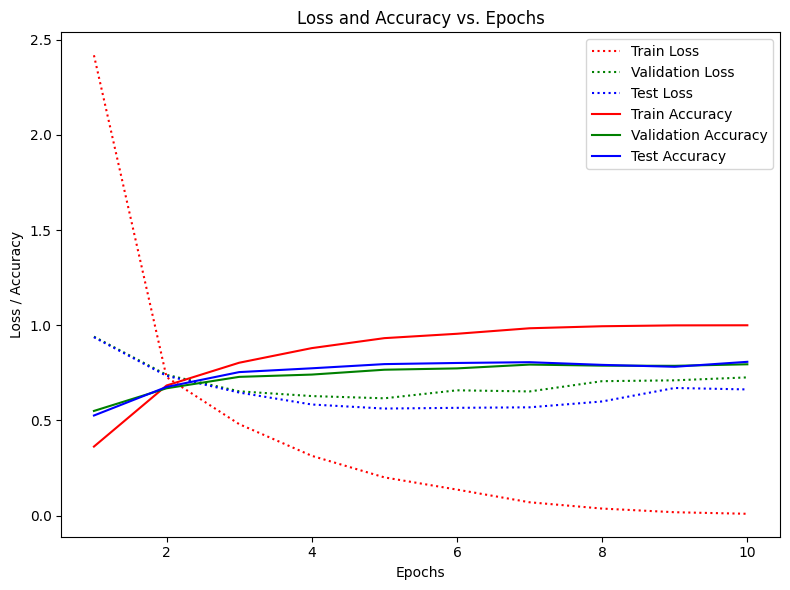

In [16]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=4, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=4, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [17]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [18]:
# # function to determine performance of model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#
#         q = queries[i][None].float().cuda()
#         t = targets[i].float().cuda()
#
#         with torch.no_grad():
#
#
#             ### MODIFY IF NECESSARY ###
#             emb_q = net(q).cpu().numpy()
#             emb_t = net(t).cpu().numpy()
#
#             dists = cdist(emb_q, emb_t)
#
#             if top == 1:
#                 pred = np.argmin(dists)
#
#                 if pred == gt[i]:
#                     cnt += 1
#
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0,:top].tolist():
#                     cnt+=1
#     return (100*cnt/gt.shape[0])

In [19]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [20]:
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn

# Define your model for task 2
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Create an instance of the model
net = Model()

# Load the pre-trained weights (if available)
# net.load_state_dict(torch.load('task2_model_weights.pth'))

# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries[i][None]).float().to(device)
        t = torch.from_numpy(targets[i]).float().to(device)

        with torch.no_grad():
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

In [21]:
print(top_1_accuracy)
print(top_3_accuracy)

24.333333333333332
68.0


In [22]:
# import torch
# import torch.nn as nn
# import numpy as np
# from scipy.spatial.distance import cdist

# # Define the model architecture
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
#         self.relu2 = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(164864, num_classes)  # Adjust the input size based on your data

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.flatten(x)
#         x = self.linear(x)
#         return x

# # Function to determine performance of the model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#         q = queries[i][None].float().to(device)
#         t = targets[i].float().to(device)

#         with torch.no_grad():
#             emb_q = net(q)
#             emb_t = net(t)

#             dists = cdist(emb_q.cpu().numpy(), emb_t.cpu().numpy())

#             if top == 1:
#                 pred = np.argmin(dists)

#                 if pred == gt[i]:
#                     cnt += 1
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0, :top].tolist():
#                     cnt += 1
#     return (100 * cnt / gt.shape[0])

# # Loading training and testing data for Task 2
# task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# X = task2['arr_0'].astype(float)
# y = task2['arr_1'].astype(int)
# gt = task2['arr_2'].astype(int)  # Ground truth
# queries = task2['arr_3'].astype(float)
# targets = task2['arr_4'].astype(float)

# # Determine the number of distinct classes in your dataset
# num_classes = len(np.unique(y))

# # Convert numpy arrays to PyTorch tensors
# X = torch.from_numpy(X).float().to(device)
# y = torch.from_numpy(y).long().to(device)
# gt = torch.from_numpy(gt).long().to(device)
# queries = torch.from_numpy(queries).float().to(device)
# targets = torch.from_numpy(targets).float().to(device)

# # Create an instance of the model
# net = Model().to(device)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# # Training loop
# num_epochs = 1
# batch_size = 32
# total_samples = X.shape[0]
# num_batches = total_samples // batch_size

# for epoch in range(num_epochs):
#     for batch_idx in range(num_batches):
#         start_idx = batch_idx * batch_size
#         end_idx = start_idx + batch_size

#         inputs = X[start_idx:end_idx]
#         labels = y[start_idx:end_idx]

#         optimizer.zero_grad()

#         # Forward pass
#         outputs = net(inputs)

#         # Compute loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#     # Print epoch loss
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# # Test the performance of the model
# top_1_accuracy = query_performance(queries, targets, gt, top=1)
# top_3_accuracy = query_performance(queries, targets, gt, top=3)

# print(f"Top-1 Accuracy: {top_1_accuracy}%")
# print(f"Top-3 Accuracy: {top_3_accuracy}%")
